In [2]:
#Imports for data handling and visualizations
#Imports for data handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

#Import for models and metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv("Walmart_Store_sales.csv")

In [4]:
#There are some missing values
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


<AxesSubplot:>

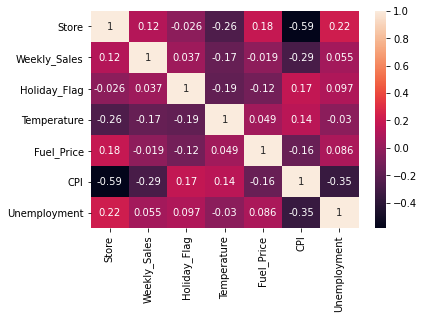

In [5]:
#Let's visualize the correlation matrix
corr = df.corr()
sns.heatmap(corr,annot=True)

In [6]:
#Let's visualize the date column to see if we should drop it
#First we have to convert it to the correct type then remove the missing values

df_date = df.loc[df["Date"].notnull(),:]
df_date.loc[:,"Date"] = df_date.loc[:,"Date"].astype("datetime64")

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
df_date.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         132 non-null    float64       
 1   Date          132 non-null    datetime64[ns]
 2   Weekly_Sales  118 non-null    float64       
 3   Holiday_Flag  122 non-null    float64       
 4   Temperature   118 non-null    float64       
 5   Fuel_Price    119 non-null    float64       
 6   CPI           122 non-null    float64       
 7   Unemployment  120 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 9.3 KB


In [8]:
fig = px.line(df_date,x="Date",y="Weekly_Sales")
fig.show()

In [9]:
df_date.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,2012-07-27,NaN,0.0,NaN,NaN,130.719581,5.936
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896


In [10]:
#The Date column isn't sorted by chronological order, we have to change it for the plot to make sense

df_date = df_date.sort_values(by="Date",ignore_index=True)
df_date.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,17.0,2010-01-10,829207.27,0.0,60.07,2.853,126.234600,6.885
1,7.0,2010-02-04,561145.14,0.0,38.26,2.725,189.704822,8.963
2,13.0,2010-02-07,2018314.71,0.0,78.82,2.814,126.139200,7.951
3,19.0,2010-02-07,1549018.68,0.0,66.25,2.958,132.521867,8.099
4,15.0,2010-02-19,660838.75,0.0,NaN,2.909,131.637000,NaN


In [11]:
fig = px.line(df_date,x="Date",y="Weekly_Sales")
fig.show()

In [12]:
#It seems to fluctuate around a mean value, we will drop the column

df = df.drop("Date",axis=1)

In [13]:
#Next we have to drop the missing values in the Weekly_Sales column

df = df.loc[df["Weekly_Sales"].notnull(),:]
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 149
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         136 non-null    float64
 1   Weekly_Sales  136 non-null    float64
 2   Holiday_Flag  125 non-null    float64
 3   Temperature   121 non-null    float64
 4   Fuel_Price    124 non-null    float64
 5   CPI           125 non-null    float64
 6   Unemployment  122 non-null    float64
dtypes: float64(7)
memory usage: 8.5 KB


In [14]:
#We now remove the outliers, as defined in this project

df = df.loc[((df["Temperature"] < df["Temperature"].mean() + 3 * df["Temperature"].std()) & (df["Temperature"] > df["Temperature"].mean() - 3 * df["Temperature"].std())),:]
df = df.loc[((df["Fuel_Price"] < df["Fuel_Price"].mean() + 3 * df["Fuel_Price"].std()) & (df["Fuel_Price"] > df["Fuel_Price"].mean() - 3 * df["Fuel_Price"].std())),:]
df = df.loc[((df["CPI"] < df["CPI"].mean() + 3 * df["CPI"].std()) & (df["CPI"] > df["CPI"].mean() - 3 * df["CPI"].std())),:]
df = df.loc[((df["Unemployment"] < df["Unemployment"].mean() + 3 * df["Unemployment"].std()) & (df["Unemployment"] > df["Unemployment"].mean() - 3 * df["Unemployment"].std())),:]

In [15]:
df.info(verbose=True)
for c in df.columns:
    print(c, df[c].isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 149
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         90 non-null     float64
 1   Weekly_Sales  90 non-null     float64
 2   Holiday_Flag  80 non-null     float64
 3   Temperature   90 non-null     float64
 4   Fuel_Price    90 non-null     float64
 5   CPI           90 non-null     float64
 6   Unemployment  90 non-null     float64
dtypes: float64(7)
memory usage: 5.6 KB
Store False
Weekly_Sales False
Holiday_Flag True
Temperature False
Fuel_Price False
CPI False
Unemployment False


In [16]:
#We replace the NaN by the mean in the column Holiday_Flag

HF_mean = df["Holiday_Flag"].mean()
df["Holiday_Flag"] = df["Holiday_Flag"].fillna(HF_mean)

In [17]:
#We now only have non-null values, we can start buillding the model
#We separate the target from the features

target_variable = "Weekly_Sales"
features_list = ["Store","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment"]
numeric_indices = [0,1,2,3,4,5]
categorical_indices = []

X = df.loc[:, features_list]
Y = df.loc[:, target_variable]

#We convert to numpy arrays

X = X.values
Y = Y.tolist()

#We divide in train and test sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#Features preprocessing

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)

#Model

regressor=LinearRegression()
regressor.fit(X_train,Y_train)
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

#Evaluation

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.15142444367568275
R2 score on test set :  0.15034231478855453


In [18]:
feat_imp = pd.DataFrame(index = range(X.shape[1]), columns = ['importance'], data = regressor.coef_)
feat_imp

,importance
0,-31188.004238
1,40970.058994
2,2202.732063
3,-85275.785056
4,-281016.688389
5,-3528.243618
